In [2]:
from PIL import Image
import numpy as np

def classify_green_pH(image_path):
    # Load the image and convert to RGB
    image = Image.open(image_path).convert('RGB')
    pixels = np.array(image)
    
    # Flatten to a list of RGB pixels
    pixels = pixels.reshape(-1, 3)
    
    # Initialize counters
    count_5 = 0  # Dark Green
    count_6 = 0  # Medium-Dark Green
    count_7 = 0  # Medium-Light Green
    count_8 = 0  # Light Green

    for r, g, b in pixels:
        # Check if green is dominant
        if g > r and g > b:
            if g < 80 and r < 70 and b < 70:
                count_8 += 1  # Very dark green → pH 8
            elif 80 <= g < 130 and r < 100 and b < 100:
                count_7 += 1  # Medium-dark green → pH 7
            elif 130 <= g < 180 and r < 130 and b < 130:
                count_6 += 1  # Medium-light green → pH 6
            elif g >= 180 and r < 170 and b < 170:
                count_5 += 1  # Light green → pH 5

    # Get max count category
    green_counts = {
        5: count_5,
        6: count_6,
        7: count_7,
        8: count_8
    }

    predicted_pH = max(green_counts, key=green_counts.get)

    print("Green pixel classification counts:")
    print(green_counts)
    print(f"Predicted pH based on green shade: {predicted_pH}")

    return predicted_pH

# Example usage
classify_green_pH("Preprocessed_Data/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W13.JPG")


Green pixel classification counts:
{5: 175195, 6: 376781, 7: 112955, 8: 10083}
Predicted pH based on green shade: 6


6

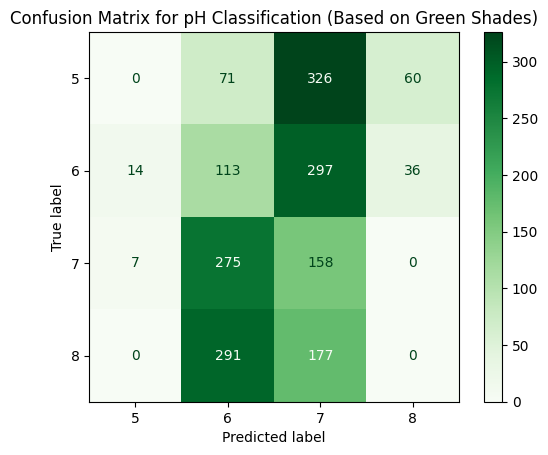


🎯 Accuracy: 14.85%


In [2]:
import os
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Step 1: Classify an image based on green shades
def classify_green_pH(image_path):
    image = Image.open(image_path).convert('RGB')
    pixels = np.array(image).reshape(-1, 3)

    count_5 = count_6 = count_7 = count_8 = 0

    for r, g, b in pixels:
        if g > r and g > b:
            if g < 80 and r < 70 and b < 70:
                count_8 += 1
            elif 80 <= g < 130 and r < 100 and b < 100:
                count_7 += 1
            elif 130 <= g < 180 and r < 130 and b < 130:
                count_6 += 1
            elif g >= 180 and r < 170 and b < 170:
                count_5 += 1

    green_counts = {
        5: count_5,
        6: count_6,
        7: count_7,
        8: count_8
    }

    predicted_pH = max(green_counts, key=green_counts.get)
    return predicted_pH

# Step 2: Walk through the dataset
def walk_dataset_and_classify(base_folder):
    actual_labels = []
    predicted_labels = []

    for root, dirs, files in os.walk(base_folder):
        for file in files:
            if file.endswith(".JPG"):
                file_path = os.path.join(root, file)
                
                # Extract actual pH from folder name
                if 'pH5' in root:
                    actual_pH = 5
                elif 'pH6' in root:
                    actual_pH = 6
                elif 'pH7' in root:
                    actual_pH = 7
                elif 'pH8' in root:
                    actual_pH = 8
                else:
                    continue  # skip unrelated folders

                # Predict pH using green classification
                predicted_pH = classify_green_pH(file_path)

                actual_labels.append(actual_pH)
                predicted_labels.append(predicted_pH)

    return actual_labels, predicted_labels

# Step 3: Plot confusion matrix
def plot_confusion(actual_labels, predicted_labels):
    labels = [5, 6, 7, 8]
    cm = confusion_matrix(actual_labels, predicted_labels, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Greens')
    plt.title("Confusion Matrix for pH Classification (Based on Green Shades)")
    plt.show()

    acc = accuracy_score(actual, predicted)
    print(f"\n🎯 Accuracy: {acc * 100:.2f}%")

# Step 4: Run everything
if __name__ == "__main__":
    dataset_path = "Preprocessed_Data"  # Adjust this if needed
    actual, predicted = walk_dataset_and_classify(dataset_path)
    plot_confusion(actual, predicted)

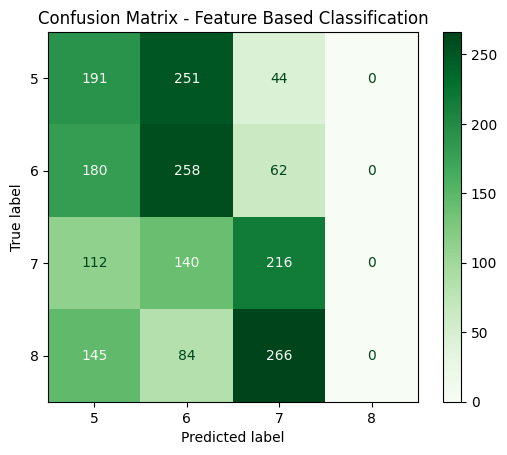


🎯 Accuracy: 34.12%


In [6]:
import os
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# --- 1. Feature Extraction ---
def extract_features(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # HSV histograms
    hist_h = cv2.calcHist([hsv], [0], None, [8], [0, 180])
    hist_s = cv2.calcHist([hsv], [1], None, [8], [0, 256])
    hist_v = cv2.calcHist([hsv], [2], None, [8], [0, 256])
    hist = np.concatenate([hist_h, hist_s, hist_v]).flatten()
    hist /= np.sum(hist)

    # Moments from RGB image
    mean = np.mean(image, axis=(0, 1))
    std = np.std(image, axis=(0, 1))
    skewness = np.mean(((image - mean) / (std + 1e-6)) ** 3, axis=(0, 1))
    moments = np.concatenate([mean, std, skewness])

    return np.concatenate([hist, moments])

# --- 2. Rule-based classifier using features ---
def classify_feature_based(features):
    mean_g = features[-6 + 1]  # mean of green channel
    std_g = features[-3 + 1]   # std dev of green channel
    skew_g = features[-0 + 1]  # skewness of green channel

    # Calibrated thresholds based on observed brightness
    if mean_g < 60:
        return 5
    elif mean_g < 75:
        return 6
    elif mean_g < 90:
        return 7
    else:
        return 8

    # if mean_g < 65:
    #     return 5
    # elif mean_g < 85:
    #     return 6 if std_g < 20 else 5
    # elif mean_g < 105:
    #     return 7 if skew_g > 0 else 6
    # else:
    #     return 8

# --- 3. Loop through dataset and apply classifier ---
def walk_and_classify_feature_based(base_path):
    actual_labels = []
    predicted_labels = []

    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith(".JPG"):
                file_path = os.path.join(root, file)

                # Label extraction
                if 'pH5' in root:
                    true_label = 5
                elif 'pH6' in root:
                    true_label = 6
                elif 'pH7' in root:
                    true_label = 7
                elif 'pH8' in root:
                    true_label = 8
                else:
                    continue

                image = cv2.imread(file_path)
                if image is None:
                    continue

                features = extract_features(image)
                predicted_label = classify_feature_based(features)

                actual_labels.append(true_label)
                predicted_labels.append(predicted_label)

    return actual_labels, predicted_labels

# --- 4. Plot confusion matrix ---
def plot_confusion(actual, predicted):
    labels = [5, 6, 7, 8]
    cm = confusion_matrix(actual, predicted, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Greens')
    plt.title("Confusion Matrix - Feature Based Classification")
    plt.show()

    acc = accuracy_score(actual, predicted)
    print(f"\n🎯 Accuracy: {acc * 100:.2f}%")

# --- 5. Run Everything ---
if __name__ == "__main__":
    base_path = "Preprocessed_Data"  # Your dataset root
    actual, predicted = walk_and_classify_feature_based(base_path)
    plot_confusion(actual, predicted)